In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [3]:
a = "/Users/weilu/Research/server/may_2019/multi_iter0/database/dompdb/1EG4A_89-207.pdb"

In [3]:
import glob

In [4]:
a_list = glob.glob("/Users/weilu/Research/server/may_2019/multi_iter0/database/dompdb/*.pdb")

In [16]:
len(a_list)

1825

In [71]:
parser = PDBParser()
all_freq = np.zeros(100)
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, 10)
    freq, bins = np.histogram(cb_density, bins=100, range=(0,10))
    all_freq += freq
#     if i == 100:
#         break

In [72]:
cb_all_freq = all_freq
cb_bins = bins

(0, 5)

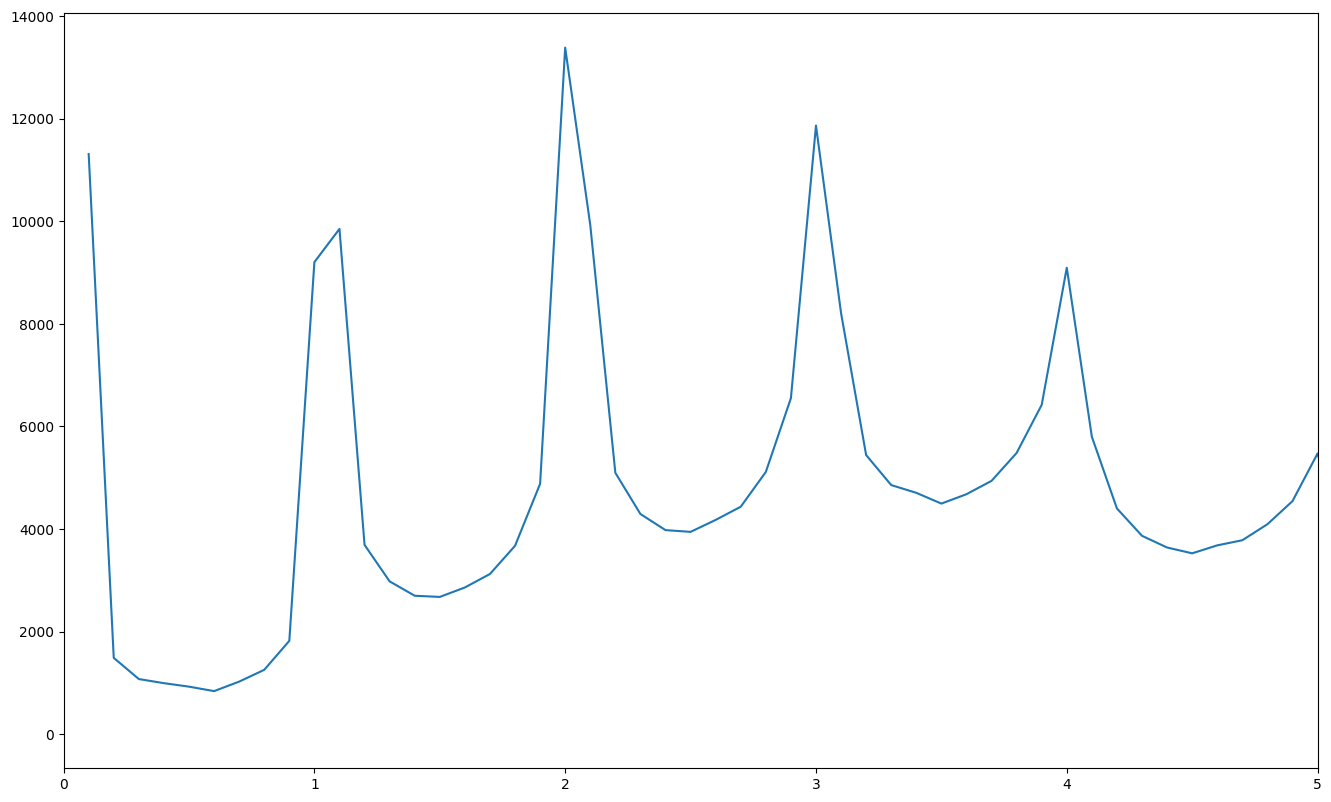

In [80]:
plt.plot(cb_bins[1:], cb_all_freq)
plt.xlim(0,5)

In [73]:
parser = PDBParser()
largest = 20
all_freq = np.zeros(largest*10)
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_weight_density(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, largest)
    freq, bins = np.histogram(cb_density, bins=largest*10, range=(0,largest))
    all_freq += freq
#     if i == 10:
#         break

In [74]:
weight_all_freq = all_freq
weight_bins = bins

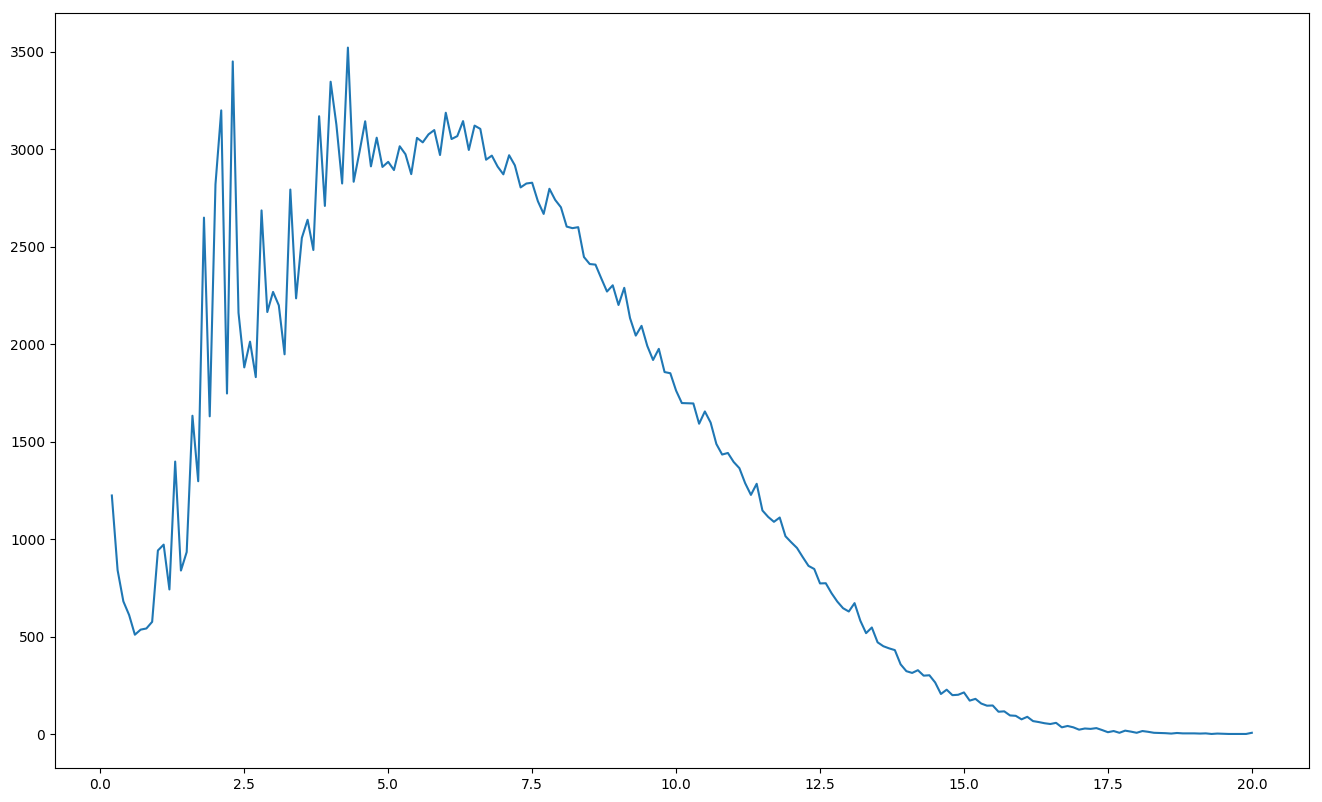

In [81]:
plt.plot(weight_bins[2:], weight_all_freq[1:])


(2, 4)

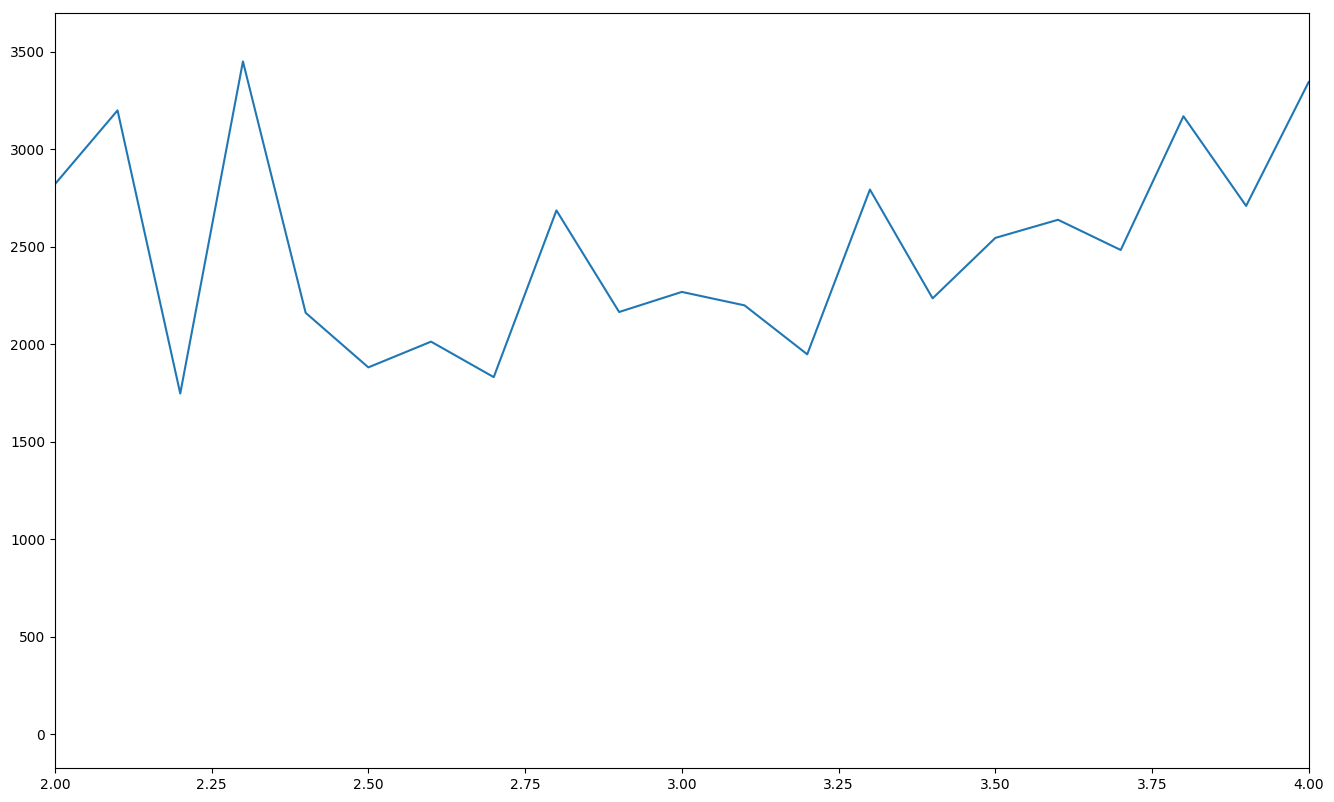

In [83]:
plt.plot(weight_bins[2:], weight_all_freq[1:])
plt.xlim(2,4)

In [10]:
parser = PDBParser()
largest = 600
all_freq = np.zeros(200)
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_weight_density_2(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, largest)
    freq, bins = np.histogram(cb_density, bins=200, range=(0,largest))
    all_freq += freq
    if i == 100:
        break

In [11]:
weight_2_all_freq = all_freq
weight_2_bins = bins

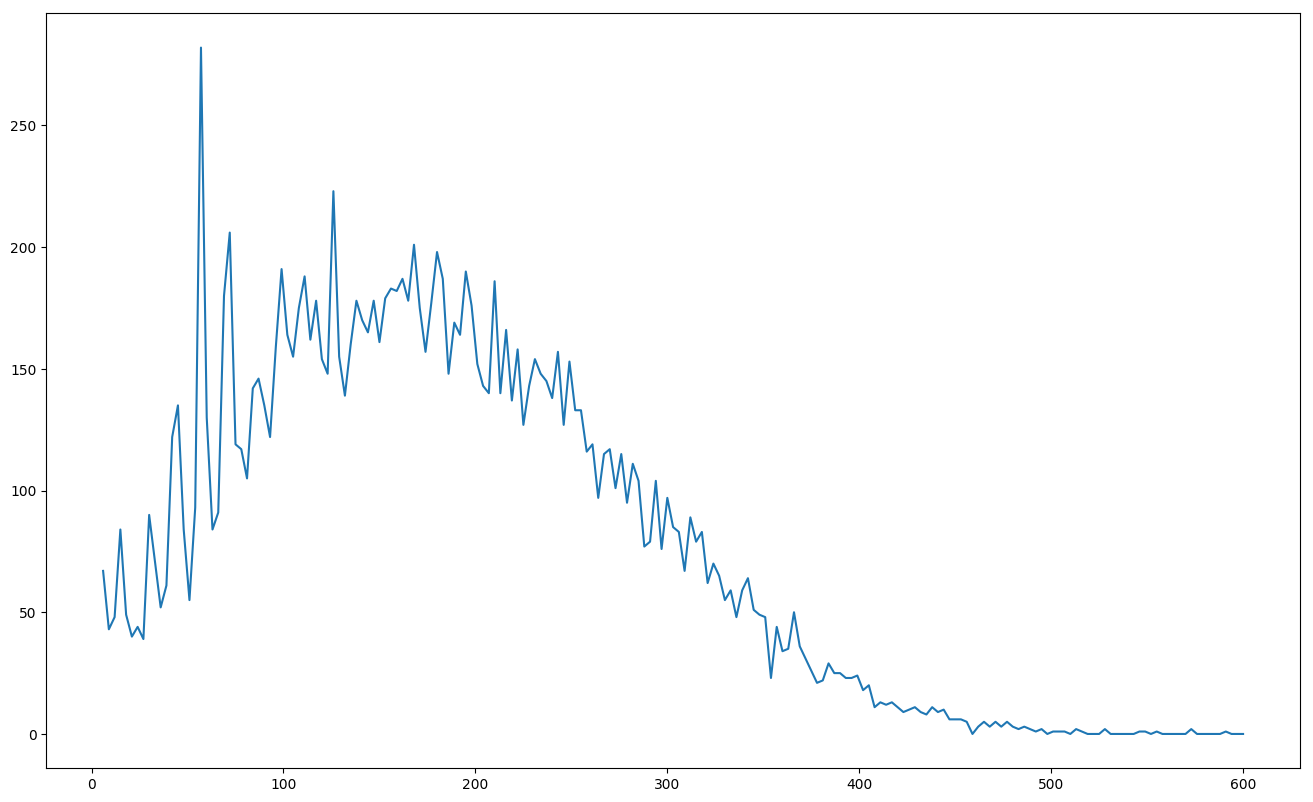

In [12]:
plt.plot(weight_2_bins[2:], weight_2_all_freq[1:])


In [5]:
def calculate_cb_weight_density_2(res_list, neighbor_list, min_seq_sep=2):
    weight_info = pd.read_csv("~/opt/parameters/amino_acid_side_chain_weight", comment="#", sep="\s+")
    weight_info["normalized_weight"] = weight_info["weight"] /(weight_info["weight"].min())
    weight_info["sideChainWeight"] = weight_info["weight"] - 56
    weight_info["normalized_weight_2"] =  (weight_info["sideChainWeight"]  /(weight_info["sideChainWeight"].min()))

    num_residues = len(res_list)
    density = np.zeros(num_residues)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 9.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if abs(res2index - res1index) >= min_seq_sep or (res1chain != res2chain):
                rij = get_interaction_distance(res1, res2)
                res2type = three_to_one(res2.get_resname())
                try:
                    # weight = float(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight"])
                    weight = float(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight_2"])
                except:
                    print(res2)
                    print(res2type)
                    print(weight_info.query(f"oneLetterCode == '{res2type}'")["normalized_weight"])
                density[res1globalindex] += weight*interaction_well(rij, 4.5, 6.5, 5)
    return density

In [100]:
parser = PDBParser()
all_freq = np.zeros(100)
largest = 20
all_ = []
for i, a in enumerate(a_list):
    structure = parser.get_structure("x", a)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    # sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    cb_density = np.clip(cb_density, 0, 10)
    cb_density_weight = calculate_cb_weight_density(res_list, neighbor_list)
    cb_density_weight_2 = calculate_cb_weight_density_2(res_list, neighbor_list)
    cb_density_weight_2 = np.clip(cb_density_weight, 0, 500)
    tmp =pd.DataFrame([cb_density, cb_density_weight, cb_density_weight_2]).T
    all_.append(tmp)
    freq, bins = np.histogram(cb_density, bins=100, range=(0,10))
    all_freq += freq
#     break
    if i == 10:
        break
data = pd.concat(all_)

In [102]:
data.columns = ["density", "weight_density", "weight_density_2"]

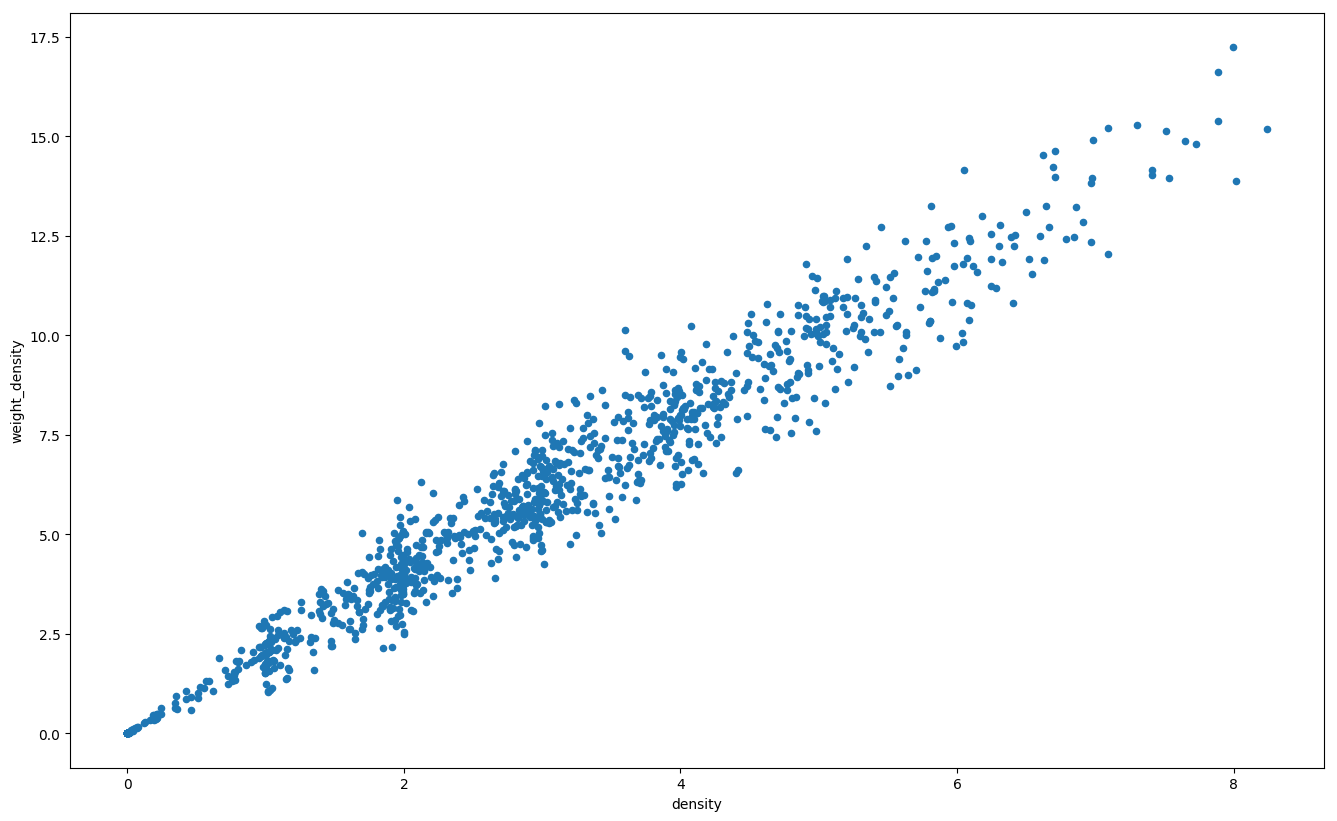

In [103]:
data.plot.scatter("density", "weight_density")

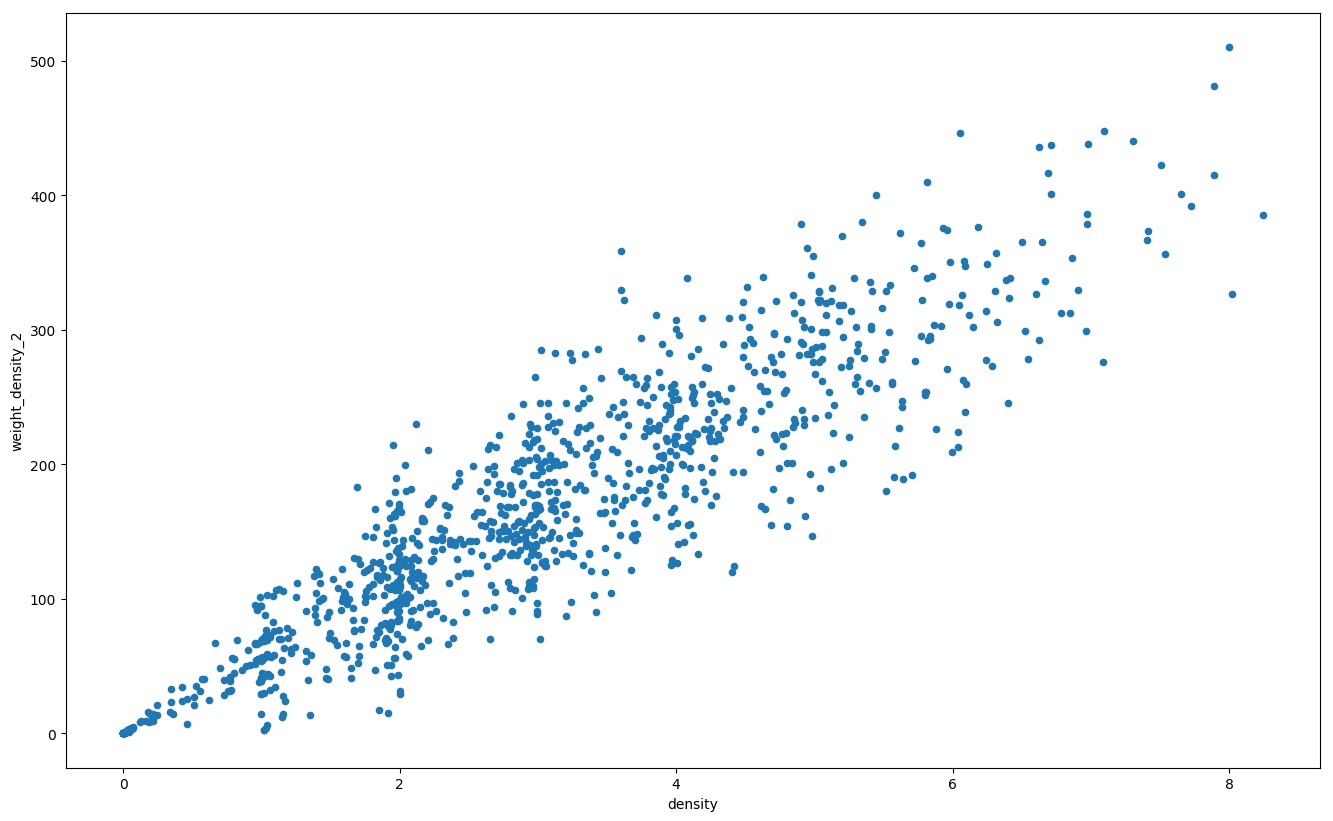

In [104]:
data.plot.scatter("density", "weight_density_2")

(array([66.,  8., 10.,  4.,  6.,  8., 10.,  9., 18.,  8., 26., 22., 10.,
        32., 12., 13., 14., 17., 20., 25., 20., 24., 22., 18., 23., 26.,
        19., 19., 33., 20., 25., 17., 21., 22., 17., 21., 19., 13., 21.,
        22., 12., 18., 21., 19., 25., 15., 14., 12., 17., 15., 15., 10.,
         7.,  7., 15., 14.,  9., 10., 11.,  8.,  8.,  8.,  9.,  9.,  9.,
         4.,  8.,  1.,  4.,  3.,  3.,  4.,  2.,  4.,  3.,  2.,  1.,  0.,
         3.,  0.,  1.,  2.,  1.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([3.74212048e-09, 5.10384723e+00, 1.02076945e+01, 1.53115417e+01,
        2.04153889e+01, 2.55192361e+01, 3.06230834e+01, 3.57269306e+01,
        4.08307778e+01, 4.59346250e+01, 5.10384723e+01, 5.61423195e+01,
        6.12461667e+01, 6.63500139e+01, 7.14538612e+01, 7.65577084e+01,
        8.16615556e+01, 8.67654028e+01, 9.18692501e+01, 9.69730973e+01,
        1.02076945e+02, 1.07180792e+02, 1.12284639e+02, 1.17388486e+02,
  

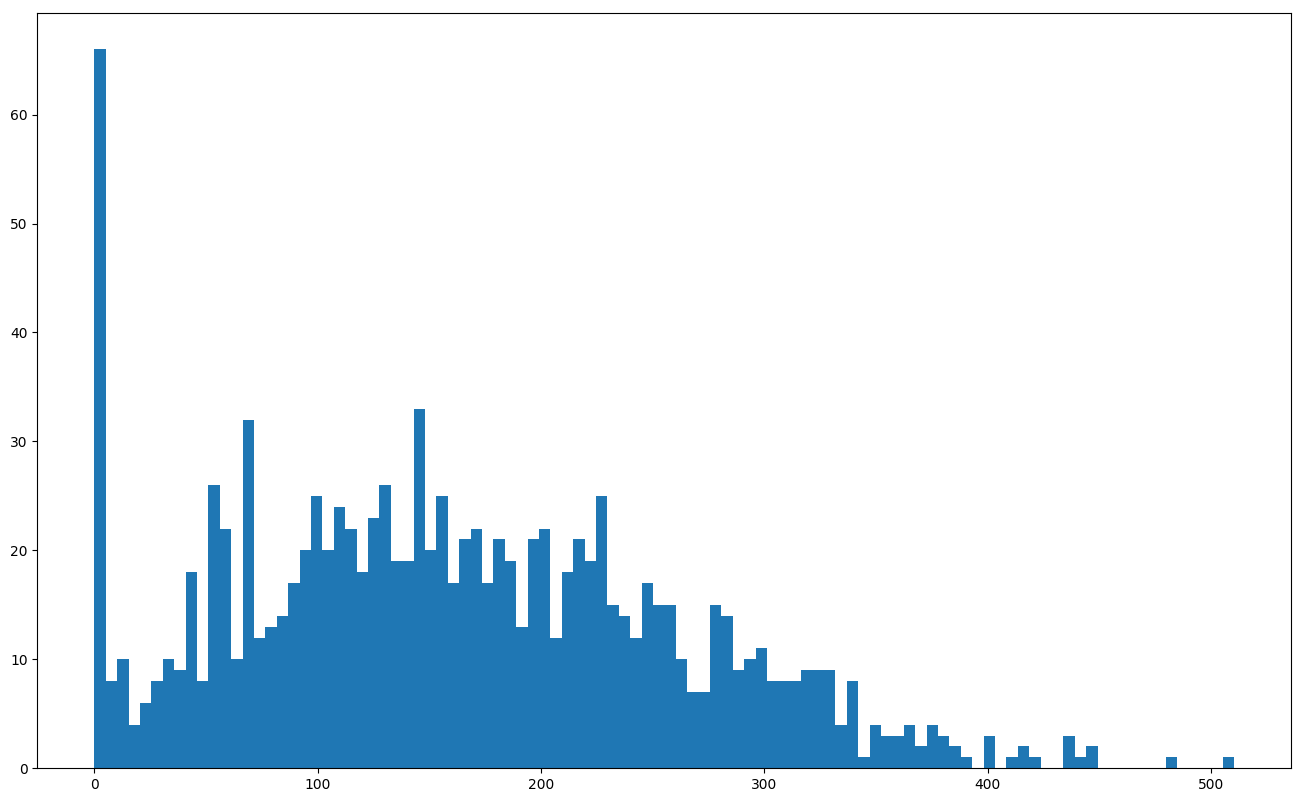

In [106]:
plt.hist(data["weight_density_2"],bins=100)

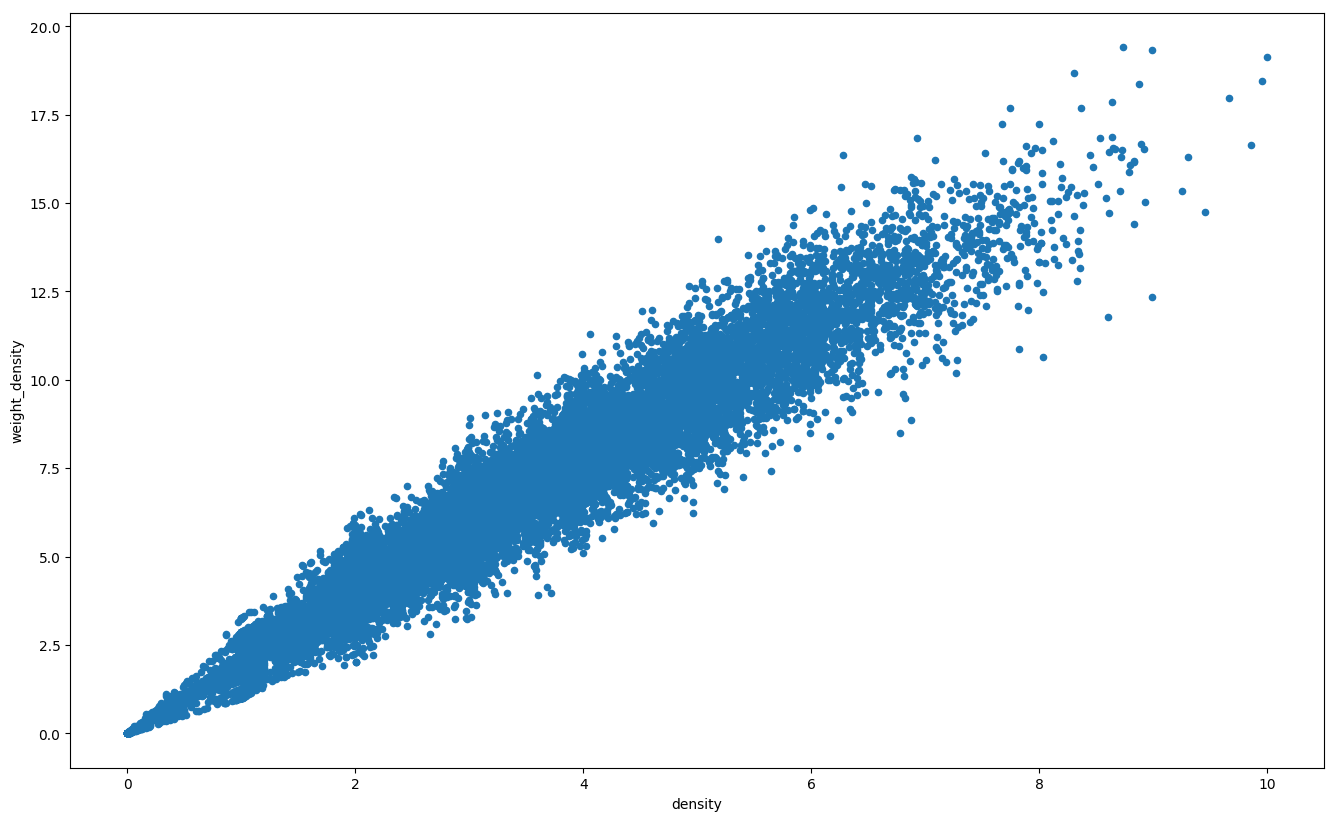

In [98]:
data.plot.scatter("density", "weight_density")

In [22]:
k_bin = 0.1
dz = np.linspace(-50,50)
y = 0.5*(1+np.tanh(k_bin*(dz-15)))

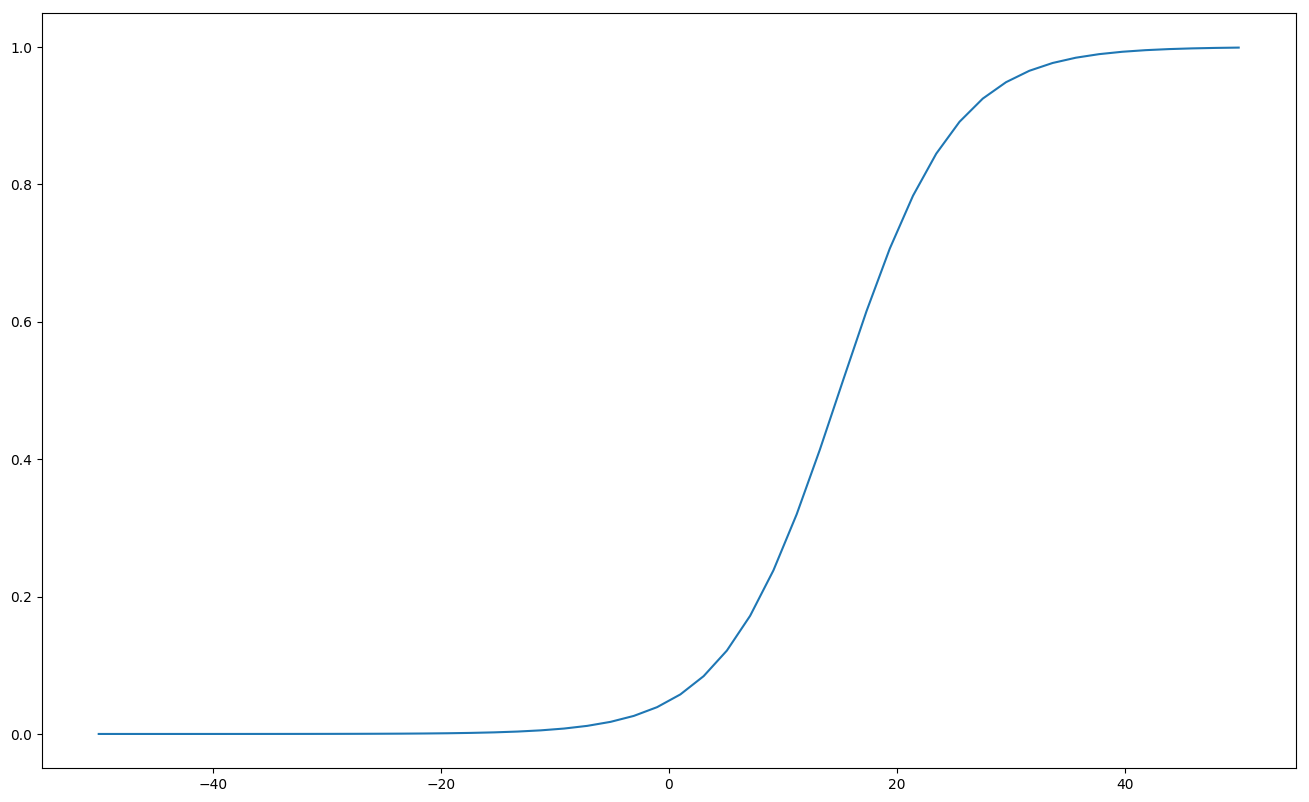

In [23]:
plt.plot(dz, y)

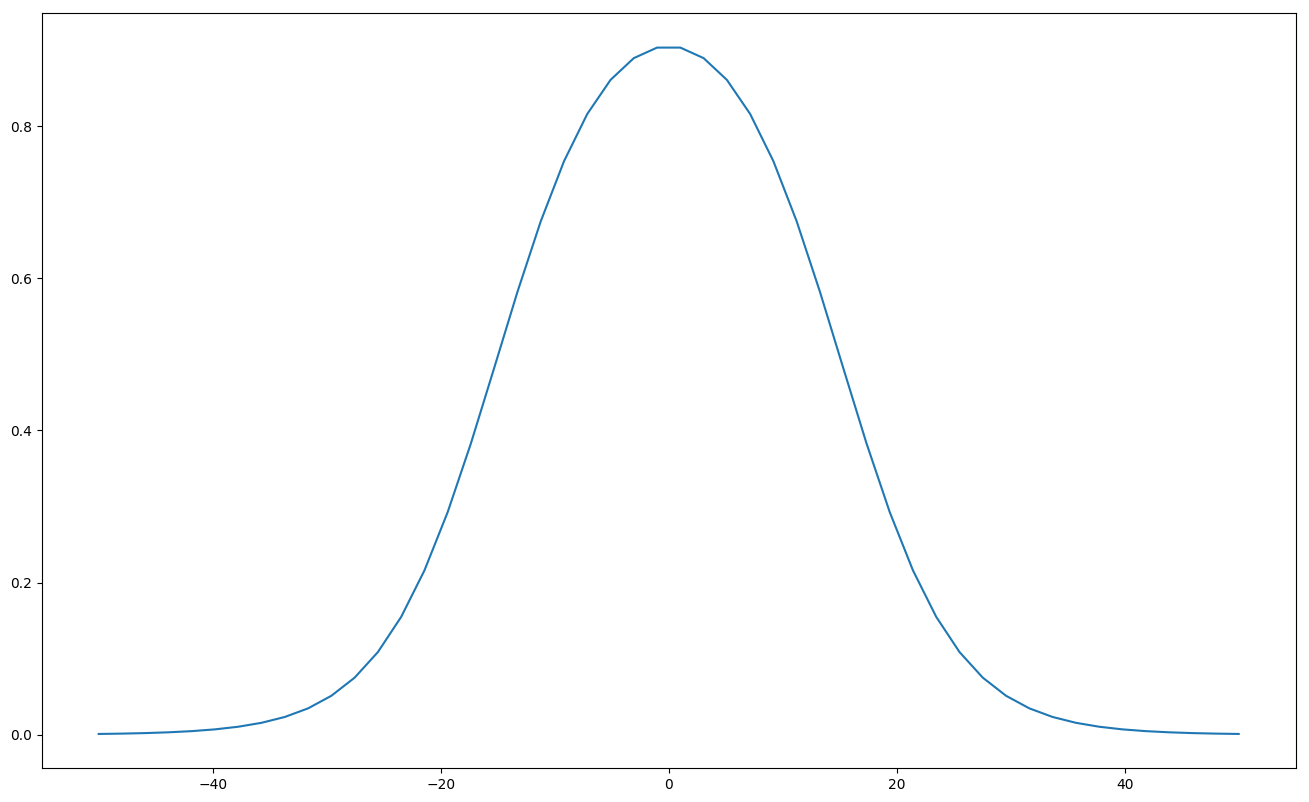

In [24]:
memb_b = 15
y = 0.5*((np.tanh(k_bin*(dz+memb_b)))+(np.tanh(k_bin*(memb_b-dz))))
plt.plot(dz, y)

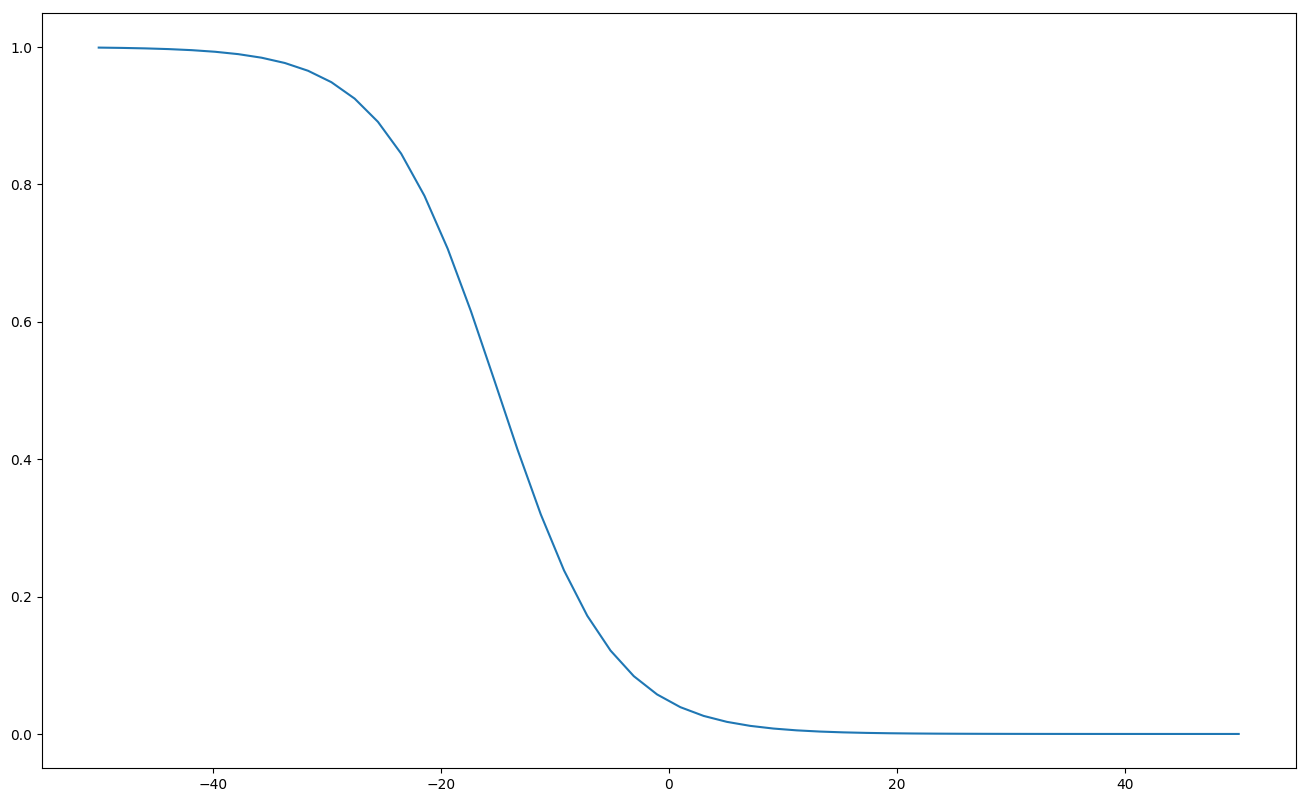

In [25]:
y = 0.5*(1+np.tanh(k_bin*(-memb_b-dz)))
plt.plot(dz, y)

In [88]:
tmp =pd.DataFrame([cb_density, cb_density_weight]).T

In [89]:
pd.concat([tmp,tmp])

,0,1
0,2.993022,4.727698
1,1.806508,3.814755
2,2.309954,4.959676
3,3.308095,6.645009
4,2.786939,5.509010
5,0.556119,1.127559
6,4.274126,8.589912
7,3.618283,7.625045
8,2.179394,5.045787
9,2.978000,5.743504


In [ ]:
values = numpy.arange(10, dtype=int)
bins = numpy.arange(-1, 11)
freq, bins = numpy.histogram(values, bins)

In [38]:
freq, bins = np.histogram([-1,1,11], bins=100, range=(0,10))

In [33]:
freq.shape

(100,)

In [41]:
all_freq

array([669.,  78.,  56.,  49.,  52.,  50.,  48.,  68., 101., 503., 523.,
       200., 125., 147., 140., 168., 168., 187., 263., 697., 567., 248.,
       217., 222., 213., 226., 216., 272., 345., 656., 459., 264., 274.,
       244., 240., 287., 263., 279., 366., 486., 341., 280., 210., 212.,
       196., 207., 209., 235., 266., 298., 240., 200., 170., 155., 119.,
       173., 151., 170., 150., 175., 130.,  92.,  84.,  76.,  82.,  59.,
        73.,  68.,  67.,  71.,  43.,  31.,  29.,  25.,  31.,  27.,  25.,
        22.,  24.,  14.,  11.,  11.,   7.,  12.,   2.,   3.,   7.,   6.,
         5.,   4.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
         2.])

In [37]:
bins

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

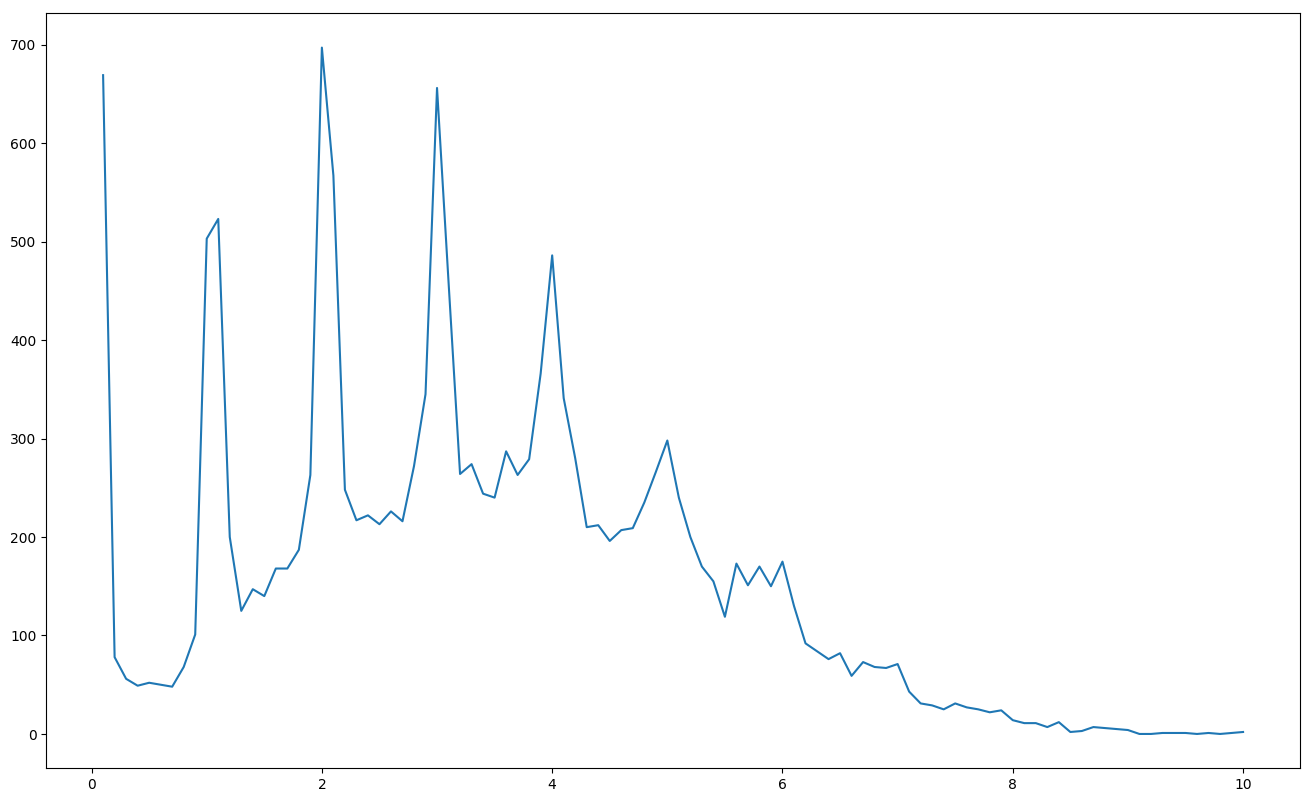

In [45]:
plt.plot(bins[1:], all_freq)


(2, 3)

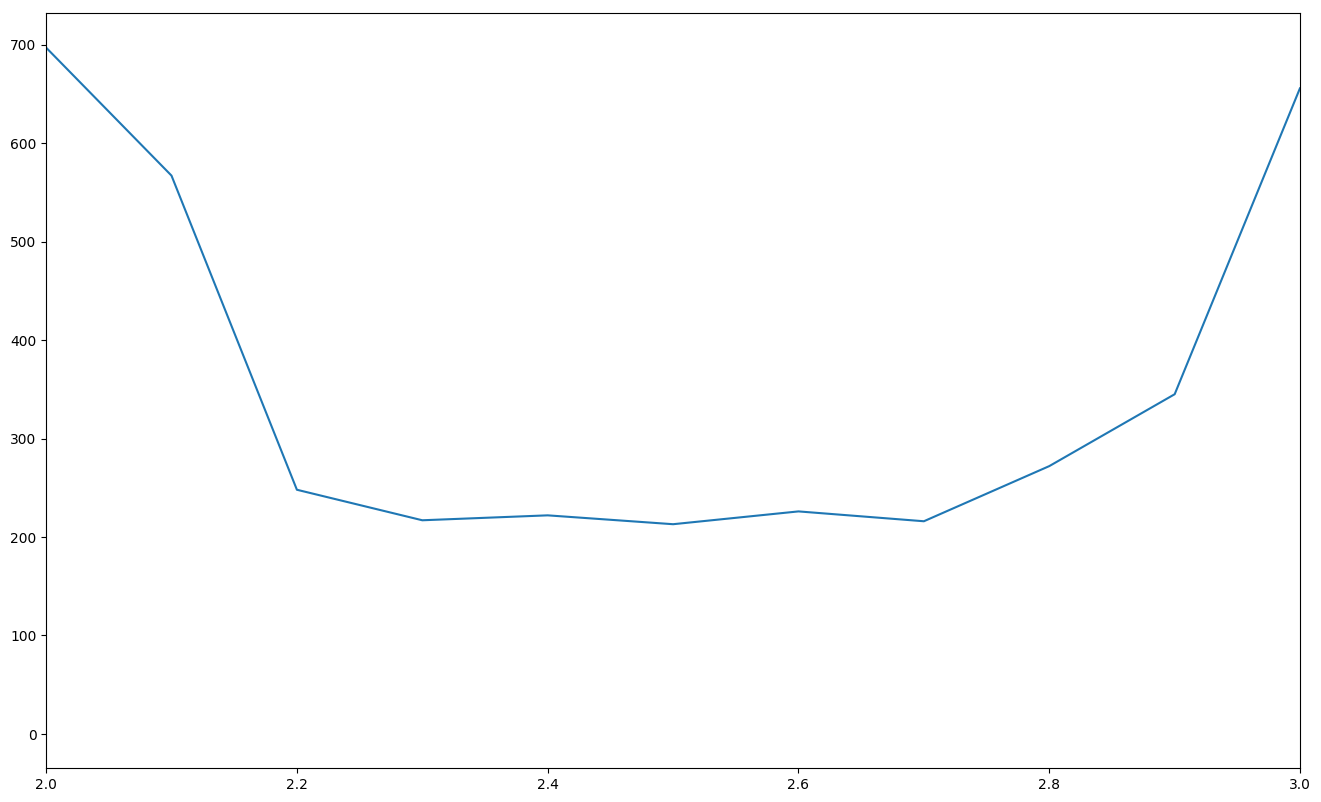

In [46]:
plt.plot(bins[1:], all_freq)
plt.xlim(2,3)

In [36]:
all_freq

array([669.,  78.,  56.,  49.,  52.,  50.,  48.,  68., 101., 503., 523.,
       200., 125., 147., 140., 168., 168., 187., 263., 697., 567., 248.,
       217., 222., 213., 226., 216., 272., 345., 656., 459., 264., 274.,
       244., 240., 287., 263., 279., 366., 486., 341., 280., 210., 212.,
       196., 207., 209., 235., 266., 298., 240., 200., 170., 155., 119.,
       173., 151., 170., 150., 175., 130.,  92.,  84.,  76.,  82.,  59.,
        73.,  68.,  67.,  71.,  43.,  31.,  29.,  25.,  31.,  27.,  25.,
        22.,  24.,  14.,  11.,  11.,   7.,  12.,   2.,   3.,   7.,   6.,
         5.,   4.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
         1.])

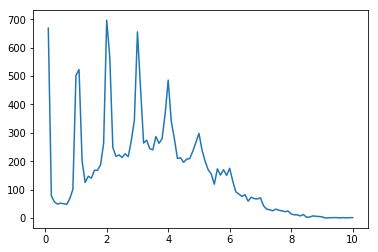

In [35]:
plt.plot(bins[1:], all_freq)

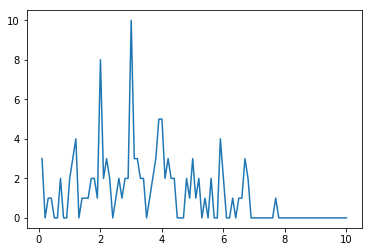

In [29]:
plt.plot(bins[1:], all_freq)

In [19]:
len(cb_density)

119

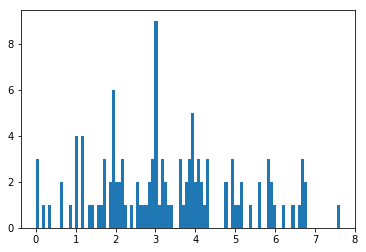

In [12]:
_ = plt.hist(cb_density, bins=100)